# Train and Tune Linear Regression Model with MultioutputRegressor

In [1]:
from pathlib import Path

import optuna.visualization as vis
import pandas as pd

from config.config import Config
from src.models.factory import Experiment
from src.models.xgboost import XGBoost
from src.plots import plot_forecast_diagnostics, plot_forecast_next_h, plot_test_overlay_h1, prep_h1_overlay, \
    prep_h_overlay
from src.runners import run_experiments
from src.utils import set_seed

In [2]:
cfg = Config(Path("../config/config.yaml"))
SEED = cfg.runtime.seed
HORIZON = cfg.runtime.horizon
rng = set_seed(SEED)

2025-08-24 14:52:30,129 - INFO - src.utils - Global random seed set to 42


In [3]:
df_full = pd.read_csv(Path(cfg.data.processed_dir) / "features_full.csv")

In [4]:
experiments = [
    Experiment(
        name="xgboost",
        build=lambda horizon, seed: XGBoost(random_state=SEED),
        include_sentiment=True
    )
]

In [5]:
results = run_experiments(df_full, Path(cfg.data.processed_dir), experiments, HORIZON, SEED)

2025-08-24 14:52:30,234 - INFO - ModelTrainer - Initialized ModelTrainer for model: xgboost
[I 2025-08-24 14:52:30,235] A new study created in memory with name: xgboost
2025-08-24 14:52:30,235 - INFO - ModelTrainer - Starting model tuning...
[I 2025-08-24 14:53:37,125] Trial 0 finished with value: 0.009857235888414055 and parameters: {'n_estimators': 700, 'learning_rate': 0.08927180304353628, 'max_depth': 8, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'min_child_weight': 1.981947943193925, 'reg_alpha': 0.05808361216819946, 'reg_lambda': 4.344263114297182, 'max_bin': 384, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.009857235888414055.
2025-08-24 14:53:37,127 - INFO - ModelTrainer - Starting model tuning...
[I 2025-08-24 14:53:52,488] Trial 1 pruned. 
2025-08-24 14:53:52,488 - INFO - ModelTrainer - Starting model tuning...
[I 2025-08-24 14:54:11,003] Trial 2 pruned. 
2025-08-24 14:54:11,004 - INFO - ModelTrainer - Starting model tuning...
[I 20

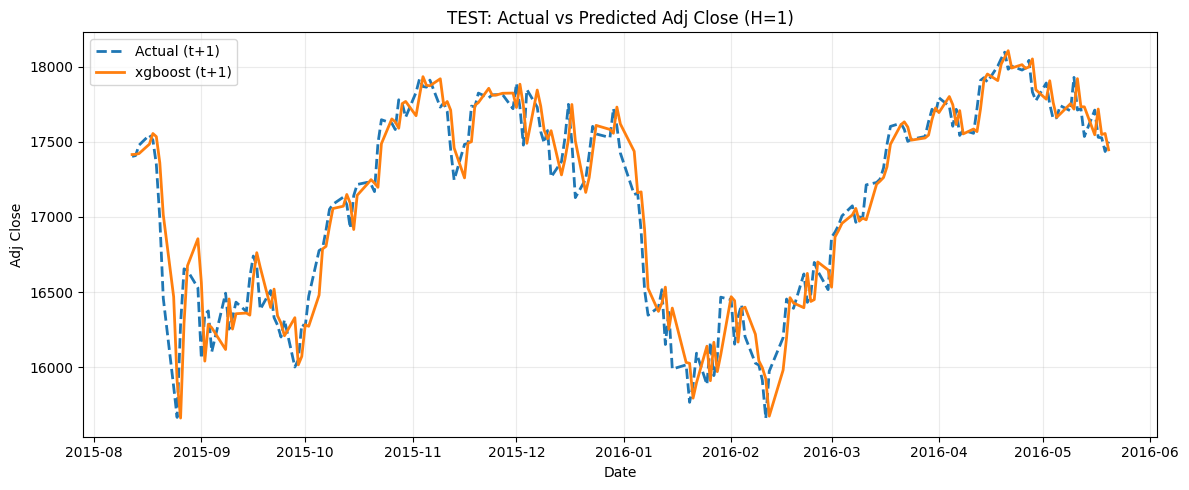

In [6]:
dates_next, actual_next, pred_next_by_model = prep_h1_overlay(df_full, results)
plot_test_overlay_h1(
    dates_next=dates_next,
    actual_next=actual_next,
    pred_next_by_model=pred_next_by_model,
    path=Path(cfg.data.fig_dir) / "xgboost_actual_vs_predicted_adj_close.png",
)

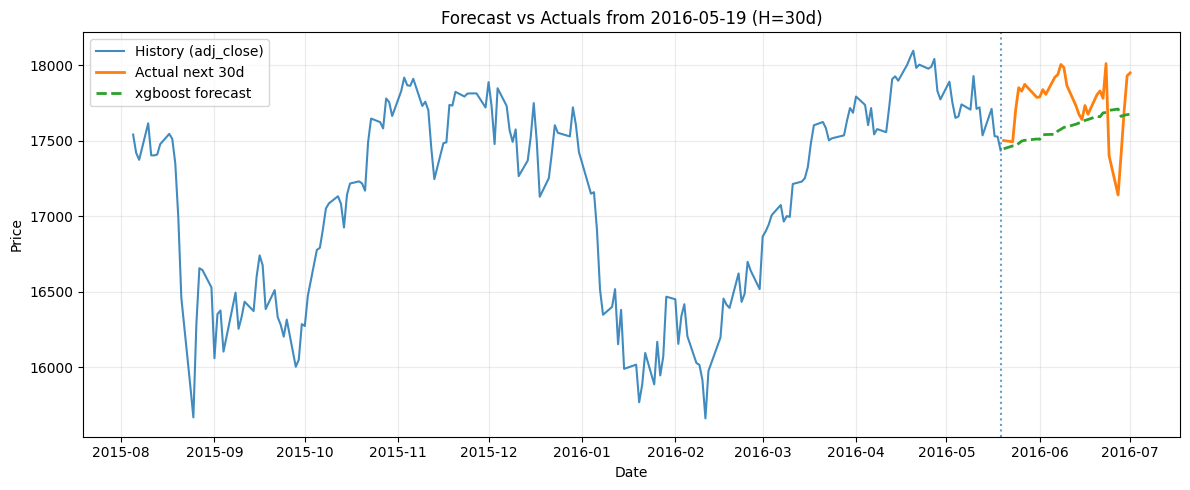

In [7]:
hist_dates, hist_prices, fut_dates, actual_path, anchor_date, paths_by_model = prep_h_overlay(df_full, results, HORIZON)
plot_forecast_next_h(
    hist_dates=hist_dates,
    hist_prices=hist_prices,
    fut_dates=fut_dates,
    forecast_paths_by_model=paths_by_model,
    actual_path=actual_path,
    anchor_date=anchor_date,
    H=HORIZON,
    path=Path(cfg.data.fig_dir) / "xgboost_forecast.png",
)

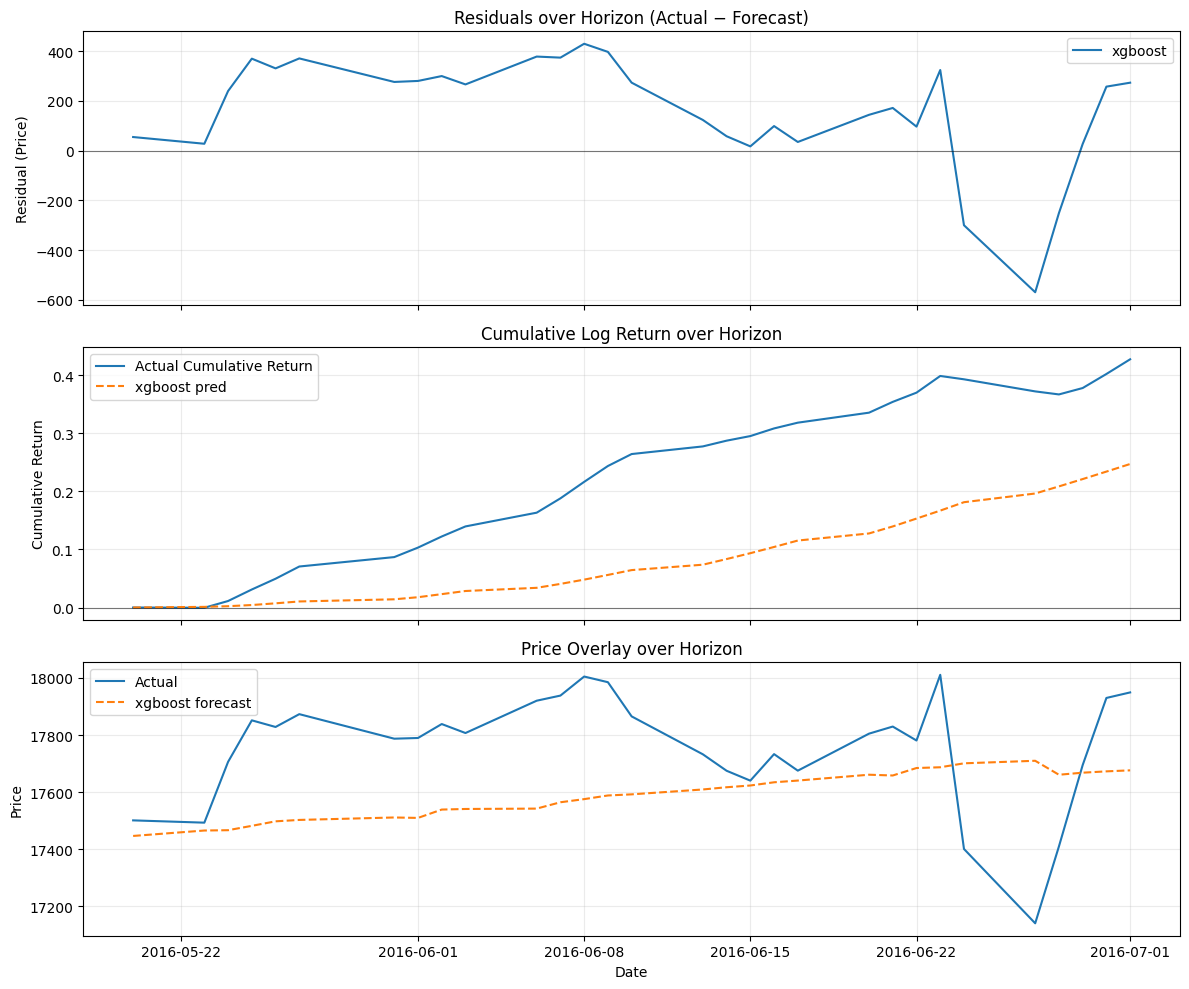

In [8]:
plot_forecast_diagnostics(
    fut_dates=fut_dates,
    actual_path=actual_path,
    forecast_paths_by_model=paths_by_model,
    path=Path(cfg.data.fig_dir) / "xgboost_forecast_diagnostics.png",
)

In [9]:
pd.DataFrame(results[0]["best_params"], index=[0])

,n_estimators,learning_rate,max_depth,subsample,colsample_bytree,min_child_weight,reg_alpha,reg_lambda,early_stopping_rounds,max_bin,grow_policy,objective,tree_method,max_leaves,random_state
0,500,0.010242,3,0.967496,0.800307,9.081741,0.221227,3.658578,100,384,lossguide,reg:squarederror,hist,320,42


In [10]:
pd.DataFrame(results[0]["metrics"]["test"], index=[0])

,mae,mse,rmse,smape,r2
0,0.007659,0.000102,0.010104,1.693694,-0.026938


In [11]:
study = results[0]["study"]

vis.plot_optimization_history(study).show()
vis.plot_param_importances(study).show()
vis.plot_slice(study).show()
vis.plot_parallel_coordinate(study).show()
vis.plot_contour(study).show()
vis.plot_edf(study).show()